In [1]:
%matplotlib inline

In [31]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import time
import pickle
from sklearn.externals import joblib
#from matplotlib import pyplot as plt

#import networkx as nx
#from networkx.utils import cuthill_mckee_ordering

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score  

import skimage.data
import skimage.exposure

import matplotlib.pyplot as plt
#import matplotlib.image

#from skimage import imread

## make pairs

In [2]:
def make_pairs(train_info):
    artists = train_info.artist.unique()

    n = train_info.groupby('artist').size()
    n = (2*n**2).sum() 
    t = pd.DataFrame(np.zeros((n, 4)), columns=['artist1', 'image1', 'artist2', 'image2'])
    i = 0
    j = 0
    for artist in artists:

        #artist info is Ax2 matrix of artist, filename
        artistInfo = train_info[train_info.artist==artist][['artist', 'filename']].values
        
        use = train_info[train_info.artist != artist ].index.values
        np.random.shuffle(use)
        
        #nm = np.min([a.shape[0]**2, train_info[train_info.artist != m].shape[0] ])
        numExamples = np.min([len(artistInfo)**2, sum(train_info.artist != artist) ])
        use = use[0:numExamples]
        
        #diffArtistInfo a Bx2 matrix of artist, filename
        diffArtistInfo = train_info[train_info.artist!=artist][['artist', 'filename']].ix[use, :].values

        
        toAdd_SameArtist = pd.DataFrame(np.concatenate([  np.repeat(artistInfo[:, 0], len(artistInfo)).reshape((-1,1)), #artist
                                            np.repeat(artistInfo[:, 1],
                                            artistInfo.shape[0]).reshape((-1,1)),
                                            np.tile(artistInfo, (len(artistInfo), 1))],
                                         axis=1),
                          columns=['artist1', 'image1', 'artist2', 'image2'])
        toAdd_SameArtist = toAdd_SameArtist.loc[0:numExamples, :]
        
        toAdd_DiffArtist = pd.DataFrame(np.concatenate([np.tile(artistInfo,
                                                  (len(artistInfo), 1))[0:len(diffArtistInfo), :],
                                          diffArtistInfo], axis=1),
                          columns=['artist1', 'image1', 'artist2', 'image2'])
        toAdd_DiffArtist = toAdd_DiffArtist.loc[0:numExamples, :]
        
        #print(j, i, a2.shape[0], b2.shape[0])
        #print(b2)
        t.iloc[i:i+len(toAdd_SameArtist), :] = toAdd_SameArtist.values
        t.iloc[i+len(toAdd_SameArtist):i+len(toAdd_SameArtist)+len(toAdd_DiffArtist), :] = toAdd_DiffArtist.values
        
        i += len(toAdd_SameArtist) + len(toAdd_DiffArtist)
        j += 1
        if j%100==0:
            print('finished %s of %s artists'%(j, len(artists)))

    print('make pairs completed')
    t = t[~t.image2.isin([np.nan, 0])]
    return t[t.image1 > t.image2]

## Get Image Info

In [3]:
def get_image_info(test_info, mydir):
    if mydir == r'/data/test_data/test':
        images = list(set(list(test_info.image1.unique()) + list(test_info.image2.unique())))
        info = pd.DataFrame(np.array(images).reshape((-1, 1)), columns = ['filename'])
    else:
        info = test_info
    
    info['pixelsx'] = np.nan
    info['pixelsy'] = np.nan
    info['size_bytes'] = np.nan
    info['r_mean'] = np.nan
    info['r_med'] = np.nan
    info['r_std'] = np.nan
    info['g_mean'] = np.nan
    info['g_med'] = np.nan
    info['g_std'] = np.nan
    info['b_mean'] = np.nan
    info['b_med'] = np.nan
    info['b_std'] = np.nan
    
    for ind, i in enumerate(info.index.values):
        try:
            #im = Image.open(mydir+'/'+info.loc[i, 'filename'])
            im = skimage.data.imread(r"/data/training_data/train/95847.jpg")
            info.loc[i, 'pixelsx'] = im.
            info.loc[i, 'pixelsy'] = im.size
            r_mean = 
            #im = cv2.imread(dir+'/'+info.loc[i, 'new_filename'])
            #info.loc[i, 'pixelsx'], info.loc[i, 'pixelsy'] = im.shape[0:2]
            info.loc[i, 'size_bytes'] = os.path.getsize(mydir+'/'+info.loc[i, 'filename']) 
            if ind%10000==0:
                print('finished %s of %s'%(ind, len(info)))
        except:
            print(mydir+'/'+info.loc[i, 'filename'])
        
    return info.rename(columns={'filename' : 'new_filename'})

In [3]:
im = skimage.data.imread(r"/data/training_data/train/95847.jpg")
#plt.imshow(im)

hist_r = skimage.exposure.histogram(im[:,:,0])
hist_g = skimage.exposure.histogram(im[:,:,1])
hist_b = skimage.exposure.histogram(im[:,:,2])

r_mean = im[:,:,0].mean()
g_mean = im[:,:,1].mean()
b_mean = im[:,:,2].mean()
r_med = np.median(im[:,:,0])
g_med = np.median(im[:,:,1])
b_med = np.median(im[:,:,2])
r_std = im[:,:,0].std()
g_bar = im[:,:,1].std()
b_var = im[:,:,2].std()

In [35]:
im = skimage.data.imread(r"/data/training_data/train/95847.jpg")

In [37]:
im.size

1108800

## Prep Data

In [4]:
#x_train, y_train, x_cv, y_cv = prep_data([train_info, None], 'cv')    
#x_test, y_test = prep_data([None, submission_info], 'test')    
def prep_data(input_info, split):
    orig_info = input_info[0]
    data = input_info[1]
    
    if split=='cv':
        artists = info.artist.unique()
        np.random.shuffle(artists)
        
        info = get_image_info(orig_info, r'/data/training_data/train')
        info['bytes_per_pixel'] = 1.0*info['size_bytes']/(info['pixelsx']*info['pixelsy'])
        info['aspect_ratio'] = 1.0*info['pixelsx']/info['pixelsy']
        train_artists = artists[0:int(0.8*len(artists))]
        test_artists = artists[int(0.8*len(artists)):]    
        
        train = make_pairs(info[info.artist.isin(train_artists)])
        test = make_pairs(info[info.artist.isin(test_artists)])
        train['in_train'] = True
        test['in_train'] = False
        data = train.append(test)
        data['sameArtist'] = data['artist1'] == data['artist2']
        
    if split=='test':

        info = get_image_info(data, r'/data/test_data/test')
        info['bytes_per_pixel'] = 1.0*info['size_bytes']/(info['pixelsx']*info['pixelsy'])
        info['aspect_ratio'] = 1.0*info['pixelsx']/info['pixelsy']
        
        data['in_train'] = False
    
        if 'artist1' in data.columns:
            data['sameArtist'] = data['artist1'] == data['artist2']

    
    data2 = pd.merge(data, info[['new_filename', 'pixelsx', 'pixelsy', 'size_bytes', 'bytes_per_pixel', 'aspect_ratio']], how='left', left_on='image1', right_on='new_filename')
    data2.drop('new_filename', 1, inplace=True)
    
    data2 = pd.merge(data2, info[['new_filename', 'pixelsx', 'pixelsy', 'size_bytes', 'bytes_per_pixel', 'aspect_ratio']], how='left', left_on='image2', right_on='new_filename')
    data2.drop('new_filename', 1, inplace=True)
    
    x_train = data2[data2.in_train==True][['pixelsx_x', 'pixelsy_x', 'size_bytes_x', 'bytes_per_pixel_x', 'aspect_ratio_x', 'pixelsx_y', 'pixelsy_y', 'size_bytes_y', 'bytes_per_pixel_y', 'aspect_ratio_y']].values
    x_test = data2[data2.in_train==False][['pixelsx_x', 'pixelsy_x', 'size_bytes_x', 'bytes_per_pixel_x', 'aspect_ratio_x', 'pixelsx_y', 'pixelsy_y', 'size_bytes_y', 'bytes_per_pixel_y', 'aspect_ratio_y']].values
    
    
    if 'artist1' in data.columns: 
        y_train = data2[data2.in_train==True]['sameArtist'].values
        y_test = data2[data2.in_train==False]['sameArtist'].values
    else:
        y_test = None    
    
    if split=='cv':        
        return x_train, y_train, x_test, y_test  
    if split=='test':
        return x_test, y_test

## Train classifier

In [5]:
def train_classifier(x_train, y_train, x_cv, y_cv):    
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=50, max_depth=8)
    
    
    #clf = xgb.XGBClassifier(n_estimators=10000, learning_rate=0.025, max_depth=4)
    print('starting fit')
    #excluding the patient_id column from the fit and prediction
    clf.fit(x_train[::5], y_train[::5])
    print('starting pred')
    
    y_pred = np.zeros(x_cv.shape[0])
    for i in xrange(4):
        y_pred[i::4] = clf.predict_proba(x_cv[i::4])[:,1] 
    
    if not y_cv is None:
        print(roc_auc_score(y_cv, y_pred))
    
    return y_pred, clf

## Main

In [6]:
def make_submission():
    train_info = pd.read_csv(r'/data/training_data/train_info.csv')
    submission_info = pd.read_csv(r'/data/test_data/submission_info.csv')
    print('prepping training and cv data')
    x_train, y_train, x_cv, y_cv = prep_data([train_info, None], 'cv')    
    print('prepping test data')
    x_test, y_test = prep_data([None, submission_info], 'test')    
    
    print('starting classifier')
    y_pred, clf = train_classifier(x_train, y_train, x_test, y_test) 

    submission = submission_info[['index']]
    submission['sameArtist'] = y_pred
    submission.to_csv('submission.csv', index=False)

## Fetch training pairs, image info

In [7]:
#load training info
train_image_info = pd.read_csv(r'/data/training_data/train_info.csv')
submission_info = pd.read_csv(r'/data/test_data/submission_info.csv')

#make training pairs
#train_pairs = make_pairs(train_image_info)
#train_pairs[ 'sameArtist' ] = train_pairs[ 'artist1' ] == train_pairs[ 'artist2' ]

#save as csv
#train_pairs.to_csv(r'/data/training_data/train_pairs.csv')

#load pairs
train_pairs = pd.read_csv(r'/data/training_data/train_pairs.csv', index_col = 0)

## Create/save/load training features

In [8]:
#get raw training data features
#raw_train_image_info = get_image_info(train_image_info, r'/data/training_data/train')
#raw_train_image_info['bytes_per_pixel'] =raw_train_image_info['size_bytes']/(raw_train_image_info['pixelsx']*raw_train_image_info['pixelsy'])
#raw_train_image_info['aspect_ratio'] = raw_train_image_info['pixelsx']/raw_train_image_info['pixelsy']

#save raw_train_image_info
#raw_train_image_info.to_csv(r'/data/training_data/raw_train_image_info.csv')

#load raw_train_image_info
raw_train_image_info = pd.read_csv(r'/data/training_data/raw_train_image_info.csv', index_col = 0)




## Join training features to training pairs

In [9]:
#join pair data to image features
raw_train_trimmed_image_info = raw_train_image_info[['new_filename',
                                                      'pixelsx',
                                                      'pixelsy',
                                                      'bytes_per_pixel',
                                                      'aspect_ratio']]
train_pairs = train_pairs.merge(raw_train_trimmed_image_info,
                                left_on='image1', right_on='new_filename')
train_pairs.rename( columns = {'pixelsx': 'pixelsx_1',
                    'pixelsy': 'pixelsy_1',
                    'bytes_per_pixel' : 'bytes_per_pixel_1',
                    'aspect_ratio':'aspect_ratio_1'},
                      inplace=True)
train_pairs = train_pairs.merge(raw_train_trimmed_image_info,
                                left_on='image2', right_on='new_filename')
train_pairs.rename( columns = {'pixelsx': 'pixelsx_2',
                    'pixelsy': 'pixelsy_2',
                    'bytes_per_pixel' : 'bytes_per_pixel_2',
                    'aspect_ratio':'aspect_ratio_2'},
                      inplace=True)

## 80/20 CV

In [11]:

### perform 80/20 cross-validation

# declare X columns
base_columns = [ 'pixelsx',
            'pixelsy',
            'bytes_per_pixel',
            'aspect_ratio']

X_columns = [ col+'_1' for col in base_columns] + [ col+'_2' for col in base_columns]

# shuffle rows
train_pairs = train_pairs.iloc[np.random.permutation(len(train_pairs))]

#split pair data into train and test
foldSize = int(len(train_pairs)/5)

CV_pairs_train = train_pairs.iloc[0:4*foldSize]
CV_pairs_test = train_pairs.iloc[4*foldSize:len(train_pairs)]

#set up Xs
CV_train_X = CV_pairs_train[X_columns]
CV_test_X = CV_pairs_test[X_columns]

#set up Ys
CV_train_Y = CV_pairs_train['sameArtist']
CV_test_Y = CV_pairs_test['sameArtist']



# CV Training/Test

In [19]:
clf = RandomForestClassifier(n_estimators=100, min_samples_split=50, max_depth=8 )

start = time.clock()

#clf = xgb.XGBClassifier(n_estimators=10000, learning_rate=0.025, max_depth=4)
print('starting fit')
#excluding the patient_id column from the fit and prediction
clf.fit(CV_train_X[0:200000], CV_train_Y[0:200000])


end = time.clock()
print('total training time: %s' % (end - start) )

pred_train = clf.predict_proba(CV_train_X[0:200000])[:,1]

training_roc = roc_auc_score(CV_train_Y[0:200000].values, pred_train)

pred_test = clf.predict_proba(CV_test_X)[:,1]

test_roc = roc_auc_score(CV_test_Y.values, pred_test)

print('training roc : %s' % training_roc)
print('test roc : %s' % test_roc)

starting fit
total training time: 22.007388


NameError: name 'pred' is not defined

## Training

In [18]:
clf = RandomForestClassifier(n_estimators=100, min_samples_split=50, max_depth=8 )

start = time.clock()

print('starting fit')
#excluding the patient_id column from the fit and prediction
clf.fit(CV_train_X, CV_train_Y)


end = time.clock()
print('total training time: %s' % (end - start) )



starting fit
total training time: 917.0945500000003


## save model

In [26]:
##save model

start = time.clock()

with open('my_dumped_classifier.pkl', 'wb') as fid:
    pickle.dump(clf, fid) 

end = time.clock()
print('total saving time: %s' % (end - start) )

total saving time: 0.012914999999338761


## load model

In [28]:
start = time.clock()

# load it again
with open('my_dumped_classifier.pkl', 'rb') as fid:
    clf = pickle.load(fid)

end = time.clock()
print('total loading time: %s' % (end - start) )



total loading time: 0.007420999999339983


## get test set features

In [53]:
#load test set definitions
test_pairs = pd.read_csv(r'/data/test_data/submission_info.csv', index_col= 0)

#get features
#raw_test_image_info = get_image_info(test_pairs, r'/data/test_data/test')

#get raw training data features
#raw_test_image_info['bytes_per_pixel'] =raw_test_image_info['size_bytes']/(raw_test_image_info['pixelsx']*raw_test_image_info['pixelsy'])
#raw_test_image_info['aspect_ratio'] = raw_test_image_info['pixelsx']/raw_test_image_info['pixelsy']

#save raw_train_image_info
#raw_test_image_info.to_csv(r'/data/test_data/raw_test_image_info.csv')

#load raw_train_image_info
#raw_test_image_info = pd.read_csv(r'/data/test_data/raw_test_image_info.csv', index_col = 0)

## join test features to test pairs

In [51]:
def joinFeaturesToPairs(image_info, image_pairs):
    #join pair data to image features
    trimmed_image_info = image_info[['new_filename',
                                     'pixelsx',
                                     'pixelsy',
                                     'bytes_per_pixel',
                                     'aspect_ratio']]
    image_pairs = image_pairs.merge(trimmed_image_info,
                              left_on='image1', right_on='new_filename')
    image_pairs.rename( columns = {'pixelsx': 'pixelsx_1',
                        'pixelsy': 'pixelsy_1',
                        'bytes_per_pixel' : 'bytes_per_pixel_1',
                        'aspect_ratio':'aspect_ratio_1'})
    image_pairs = image_pairs.merge(trimmed_image_info,
                                    left_on='image2', right_on='new_filename')
    train_pairs.rename( columns = {'pixelsx': 'pixelsx_2',
                        'pixelsy': 'pixelsy_2',
                        'bytes_per_pixel' : 'bytes_per_pixel_2',
                        'aspect_ratio':'aspect_ratio_2'})
    return train_pairs

test_pairs_final = joinFeaturesToPairs(raw_test_image_info, test_pairs)

## test on test set

In [24]:
test_predictions = clf.pred(test_pairs_final)

['mymodel.pkl',
 'mymodel.pkl_01.npy',
 'mymodel.pkl_02.npy',
 'mymodel.pkl_03.npy',
 'mymodel.pkl_04.npy',
 'mymodel.pkl_05.npy',
 'mymodel.pkl_06.npy',
 'mymodel.pkl_07.npy',
 'mymodel.pkl_08.npy',
 'mymodel.pkl_09.npy',
 'mymodel.pkl_10.npy',
 'mymodel.pkl_11.npy',
 'mymodel.pkl_12.npy',
 'mymodel.pkl_13.npy',
 'mymodel.pkl_14.npy',
 'mymodel.pkl_15.npy',
 'mymodel.pkl_16.npy',
 'mymodel.pkl_17.npy',
 'mymodel.pkl_18.npy',
 'mymodel.pkl_19.npy',
 'mymodel.pkl_20.npy',
 'mymodel.pkl_21.npy',
 'mymodel.pkl_22.npy',
 'mymodel.pkl_23.npy',
 'mymodel.pkl_24.npy',
 'mymodel.pkl_25.npy',
 'mymodel.pkl_26.npy',
 'mymodel.pkl_27.npy',
 'mymodel.pkl_28.npy',
 'mymodel.pkl_29.npy',
 'mymodel.pkl_30.npy',
 'mymodel.pkl_31.npy',
 'mymodel.pkl_32.npy',
 'mymodel.pkl_33.npy',
 'mymodel.pkl_34.npy',
 'mymodel.pkl_35.npy',
 'mymodel.pkl_36.npy',
 'mymodel.pkl_37.npy',
 'mymodel.pkl_38.npy',
 'mymodel.pkl_39.npy',
 'mymodel.pkl_40.npy',
 'mymodel.pkl_41.npy',
 'mymodel.pkl_42.npy',
 'mymodel.pkl_43.n

 ## prepare submission
    

In [ ]:
submission = submission_info[['index']]
submission['sameArtist'] = y_pred
submission.to_csv('submission.csv', index=False)

## scratch

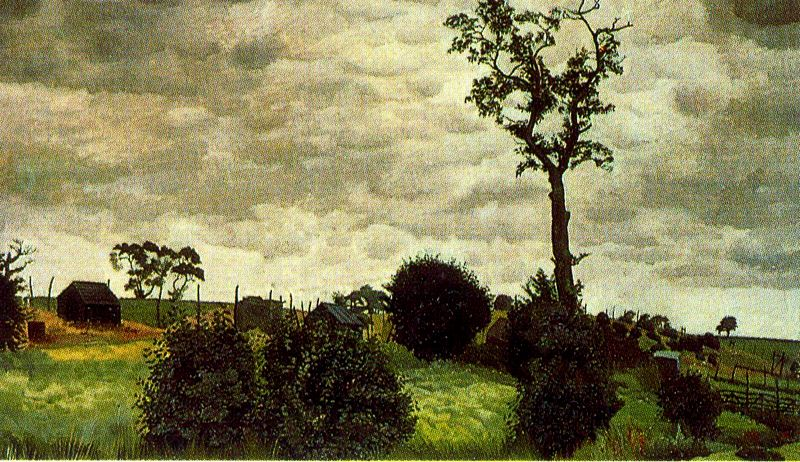

In [28]:
Image(filename = r"/data/training_data/train/95847.jpg", width=300)

In [26]:
train_pairs.iloc[100000]

artist1              56221362cba30b7e0c96111cc38c5fcd
image1                                      95847.jpg
artist2              56221362cba30b7e0c96111cc38c5fcd
image2                                      18646.jpg
sameArtist                                       True
new_filename_x                              95847.jpg
pixelsx_1                                         800
pixelsy_1                                         462
bytes_per_pixel_1                            0.376856
aspect_ratio_1                                 1.7316
new_filename_y                              18646.jpg
pixelsx_2                                         725
pixelsy_2                                         800
bytes_per_pixel_2                            0.483307
aspect_ratio_2                                0.90625
Name: 100000, dtype: object

array([  5.88930182e-05,   9.70519969e-05,   4.30022404e-04, ...,
         4.43788020e-04,   7.79837687e-03,   5.50017712e-04])

In [ ]:
### perform 5-fold cross validation

# shuffle rows
# train_pairs = train_pairs.iloc[np.random.permutation(len(train_pairs))]

# for cv_num in range(0,5):
#     len(train_pairs)/5 = chunkSize
#     if cv_num > 0:
#         test_start = i*chunkSize
#         test_end = (i+1)*chunkSize
#         train_start
#         train_end
#split training examples into 5 groups


#split training examples into CV_Train_X and CV_Train_Y, also create CV_Test